This file contains the time series modeling portion of the project. The preprocessed data is found from data.csv

In [1]:
# Relevant imports
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Load the preprocessed data
# For details on the dataframe structure, see the preprocessing Jupyter notebook

df = pd.read_csv('data.csv')
print(df.columns)

# Need to transform times into datetime objects
df['Aika'] = pd.to_datetime(df['Aika'])

if df.index.name is None:
    # Set the index of the dataframe as the date column
    df.set_index('Aika', inplace=True)


Index(['Aika', 'Hinta (snt/kWh)', 'Keskituulen nopeus [m/s]',
       'Lämpötilan keskiarvo [°C]', 'Kulutus (kWh/h)', 'Tuotanto (kW)',
       'is_holiday'],
      dtype='object')


In [3]:
# Start off with just the data from 2024
df_2024 = df.loc[datetime(2024,1,1,1):]

# In fact, take two last weeks of the data set out for checking predictive performance of the model
df_2024_train = df_2024.loc[:datetime(2024,9,4)].reset_index(drop=True)
df_2024_test = df_2024.loc[datetime(2024,9,4):].reset_index(drop=True)

# Based on some web browsing, let's try a SARIMAX model
# SARIMAX
# Seasonal
# AutoRegressive
# Integrated
# Moving Average
# with eXogenous variables

price = df_2024_train['Hinta (snt/kWh)']
inputs = df_2024_train[['Keskituulen nopeus [m/s]', 'Lämpötilan keskiarvo [°C]', 'Kulutus (kWh/h)', 'Tuotanto (kW)']]

# The order and seasonal_order parameters should be iterated over to see which models yields the best result
model = SARIMAX(endog=price, exog=inputs, order=(1,1,1), seasonal_order=(1,1,1,24))
model_fit = model.fit()

# Check the forecast from this initial try
forecast = model_fit.forecast(steps=24, exog=df_2024_test[['Keskituulen nopeus [m/s]', 'Lämpötilan keskiarvo [°C]', 'Kulutus (kWh/h)', 'Tuotanto (kW)']][:24])

c:\Users\viltz\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


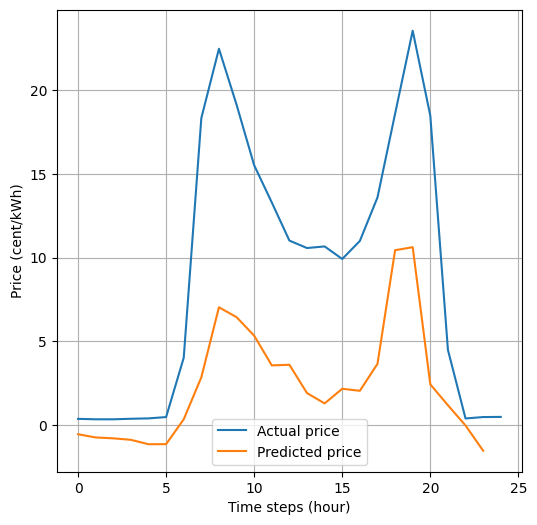

In [4]:
# Plot the prediction
df_pred = pd.DataFrame({'price': forecast}).reset_index(drop=True)

plt.figure(figsize=(6,6))
plt.plot(df_2024_test.loc[:24].index, df_2024_test.loc[:24]['Hinta (snt/kWh)'], label='Actual price')
plt.plot(df_pred.index, df_pred['price'], label='Predicted price')
plt.xlabel('Time steps (hour)')
plt.ylabel('Price (cent/kWh)')
plt.grid(True)
plt.legend()

# Scaling is off but the characteristic of the prediction seems alright....

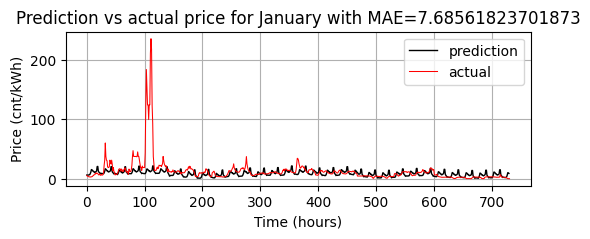

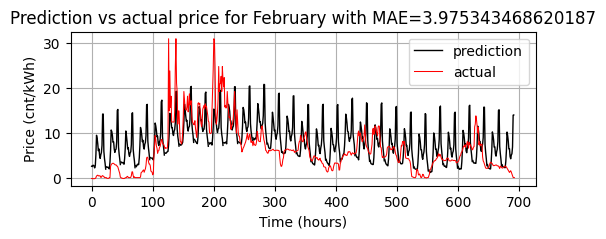

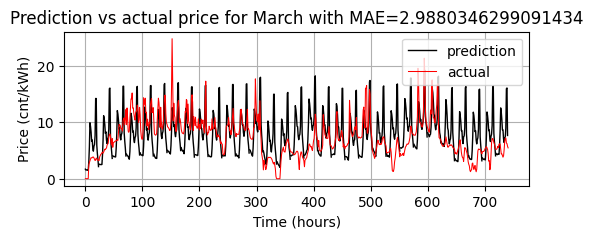

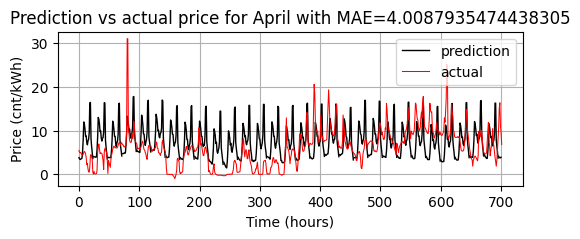

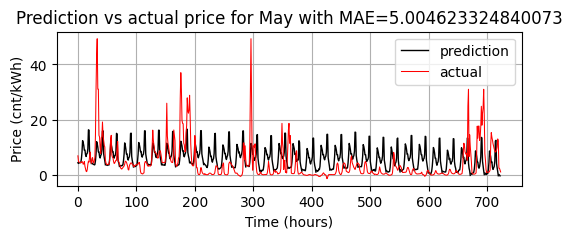

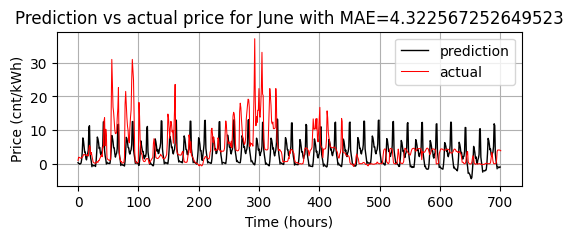

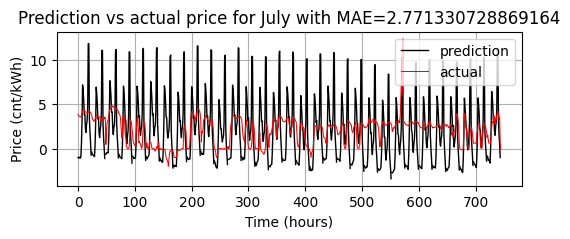

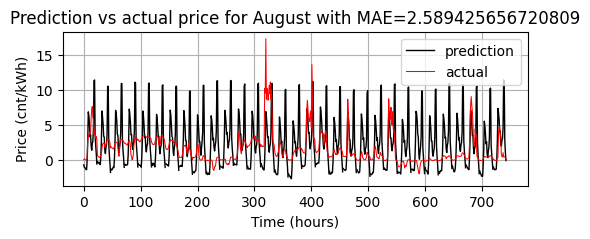

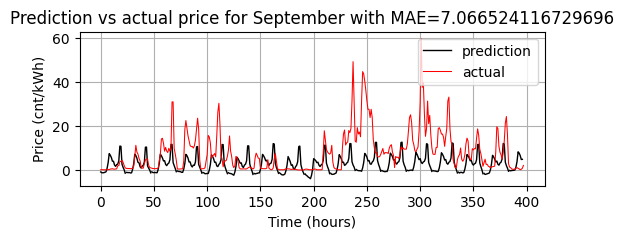

The total MAE for 2024 is 4.490251218089018


In [5]:
# Do a proper plot of utilizing the obtained time series model

# Sadly this function does not currently work due to missing rows in the dataframe, I guess they disappeared due to merging with some frame with missing rows
def plot_year(df, desired_timedelta=timedelta(days=1)):
    st_idx = df.index[0]
    N_steps = int(desired_timedelta.total_seconds()//3600)
    plt.figure(figsize=(20,10))
    while st_idx < df.index[len(df)-1]:  # Need to leave timedelta_hours indices for last prediction
        if (desired_timedelta <= (df.index[len(df)-1-N_steps] - st_idx)):
            end_idx = st_idx + desired_timedelta - timedelta(hours=1)
        else:
            end_idx = df.index[len(df)-1-N_steps]
        X = pd.date_range(st_idx, end_idx, freq='h')
        Y = df[['Keskituulen nopeus [m/s]', 'Lämpötilan keskiarvo [°C]', 'Kulutus (kWh/h)', 'Tuotanto (kW)']][st_idx:end_idx]
        forecast = model_fit.forecast(steps=len(X), exog=Y)
        plt.plot(X, forecast, color='blue')
    plt.plot(df.index, df["Hinta (snt/kWh)"], color='red')
    plt.ylabel('Price (snt/kWh)')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()

def compute_MAE(act, pred):
    return np.mean(np.abs(act-pred))

# Not the cleanest solution, but will do for now since some rows are missing
def plot_year_hacky(df, model_fit, desired_timedelta=timedelta(days=1)):
    prediction_steps = int(desired_timedelta.total_seconds()//3600)
    df_2 = df.reset_index(drop=True)
    plt.figure(figsize=(6,2))
    st_idx = 0
    max_st_idx = df_2.index[len(df_2)-1]
    maes = []
    while st_idx < max_st_idx:
        if (st_idx + prediction_steps < max_st_idx):
            end_idx = st_idx + prediction_steps
        else:
            end_idx = max_st_idx
        Y = df_2[['Keskituulen nopeus [m/s]', 'Lämpötilan keskiarvo [°C]', 'Kulutus (kWh/h)', 'Tuotanto (kW)']][st_idx:end_idx]
        forecast = model_fit.forecast(steps=end_idx-st_idx, exog=Y)
        st_idx_nxt = end_idx
        if st_idx_nxt >= max_st_idx: 
            plt.plot(df_2.index[st_idx:end_idx], forecast, color='black', linewidth=1, label='prediction')
        else:
            plt.plot(df_2.index[st_idx:end_idx], forecast, color='black', linewidth=1)
        maes.append(compute_MAE(df_2["Hinta (snt/kWh)"][st_idx:end_idx].values, forecast.values))
        st_idx = end_idx
    plt.plot(df_2.index, df_2["Hinta (snt/kWh)"], color='red', linewidth=0.75, label='actual')
    plt.grid(True)
    plt.xlabel('Time (hours)')
    plt.ylabel('Price (cnt/kWh)')
    plt.title(f'Prediction vs actual price for {df.index[0].strftime("%B")} with MAE={np.mean(maes)}')
    plt.legend(loc=1)
    plt.show()
    return np.mean(maes)


# Plot monthly prediction vs actual price for 2024
cumulative_MAE = np.zeros(9)
for i in range(1,10):
        df_i = df[datetime(2024,i,1,0):datetime(2024,i+1,1,0)]
        cumulative_MAE[i-1] = plot_year_hacky(df_i, model_fit)
print(f'The total MAE for 2024 is {np.mean(cumulative_MAE)}')
   

c:\Users\viltz\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


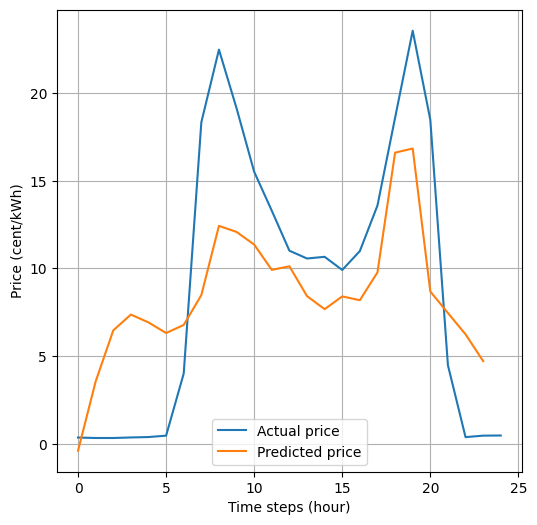

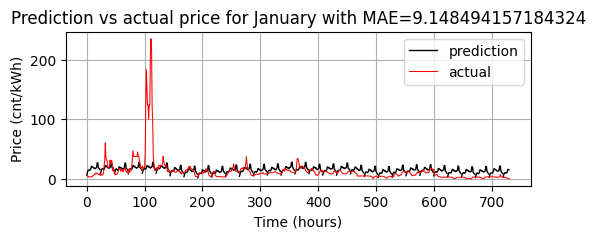

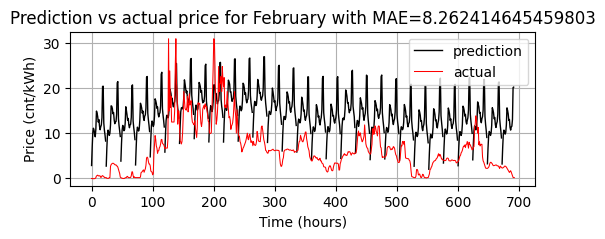

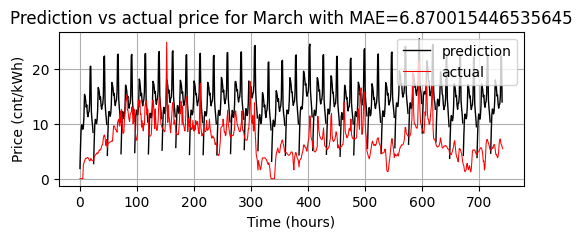

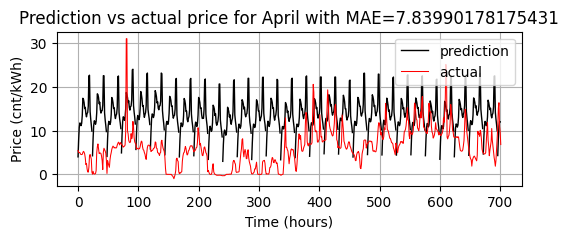

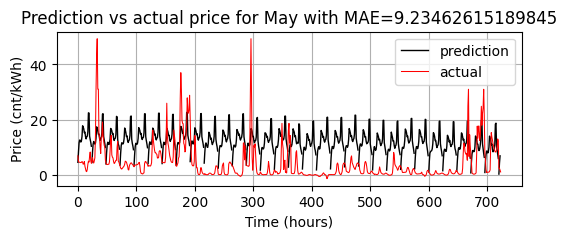

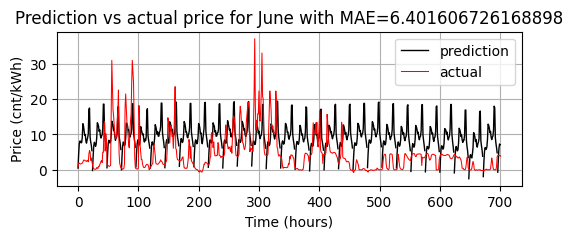

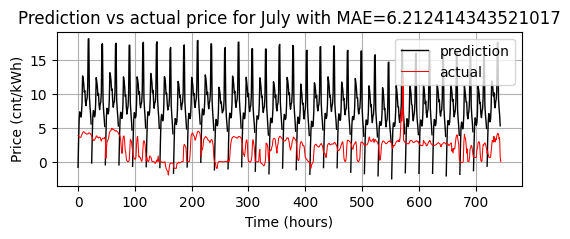

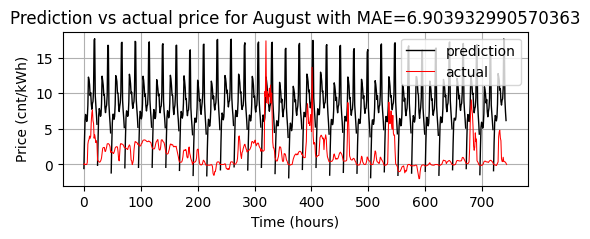

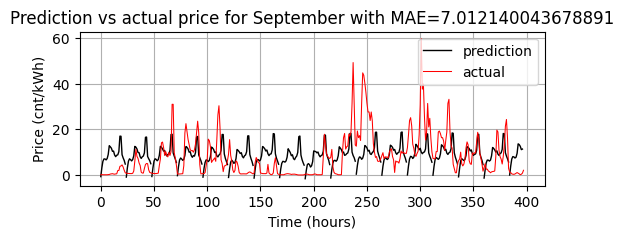

The total MAE for 2024 is 7.542838476307967


In [6]:
test_input = df_2024_test[['Keskituulen nopeus [m/s]', 'Lämpötilan keskiarvo [°C]', 'Kulutus (kWh/h)', 'Tuotanto (kW)']][:24]
def fit_SARIMAX(order, seasonal_order):
    mdl = SARIMAX(endog=price, exog=inputs, order=order, seasonal_order=seasonal_order)
    mdl_fit = mdl.fit()

    fcast = mdl_fit.forecast(steps=24, exog=test_input)

    predictions = pd.DataFrame({'price': fcast}).reset_index(drop=True)
    plt.figure(figsize=(6,6))
    plt.plot(df_2024_test.loc[:24].index, df_2024_test.loc[:24]['Hinta (snt/kWh)'], label='Actual price')
    plt.plot(predictions.index, predictions['price'], label='Predicted price')
    plt.xlabel('Time steps (hour)')
    plt.ylabel('Price (cent/kWh)')
    plt.grid(True)
    plt.legend()
    plt.show()
    return mdl_fit

moodel_fit = fit_SARIMAX((6,1,2), (1,1,1,24))

cumulative_MAE = np.zeros(9)
for i in range(1,10):
        df_i = df[datetime(2024,i,1,0):datetime(2024,i+1,1,0)]
        cumulative_MAE[i-1] = plot_year_hacky(df_i, moodel_fit)
print(f'The total MAE for 2024 is {np.mean(cumulative_MAE)}')